# NoVaS

This notebook contains the results of volatlity forecasting with the NoVaS transformation (see Politis 2007) on S&P500 returns.

Need to implement:
- ~~Simple NoVaS~~
- Exponential NoVaS

Regular ARCH model is expressed as $\frac{X_t}{\sqrt{a + \sum_{i=1}^{p} a_i X^{2}_{t-i}}}$

NoVaS is a slight improvement where we include the value of $X_t$ from an empirical causal estimate of the standard deviation of $X_t$. Hence, we may define the new "studentized" quantity as 

$$ W_{t,a} = \frac{X_t}{\sqrt{\alpha s^2_{t-1} + a_0 X^2_{t} + \sum_{i=1}^{p} a_i X^2_{t-i}}} $$

Algorithm for Simple NoVaS:

- Let $\alpha=0$ and $a_i = \frac{1}{p+1}$ for all $ 0 \leq i \leq p$
- Pick $p$ such that $|KURT_{n}(W_{t,p}^{S}) - 3 |$ is minimized

Algorithm for Exponential NoVaS:

- Let p take a very high starting value, for example, let $p \approx \frac{n}{4}$ or $\frac{n}{5}$
- Let $\alpha = 0$ and $ a_i = c'e^{-ci}$ for all $0 \leq i \leq p$, where $ c' = \frac{1}{\sum_{i=0}^{p} e^{-ci}}$
- Pick c in such a way that $|KURT_{n}(W_{t,c}^{E}) - 3|$ is minimized

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

In [3]:
# data read in, adjustment and conversion to returns
sp500_data = pd.read_csv("./data/sp500index.csv")
sp500_data.index = sp500_data["Date"].astype('datetime64[ns]')
sp500_data.drop(columns=['Date'],inplace=True)

# convert to returns
sp500_returns = sp500_data['Close'].pct_change()[1:]

## S&P 500 Returns Exploration

In [3]:
# testing kurtosis functions
scipy_kurtosis = kurtosis(sp500_returns, fisher=False)
print("Scipy version:", scipy_kurtosis)

Scipy version: 23.84959871116602


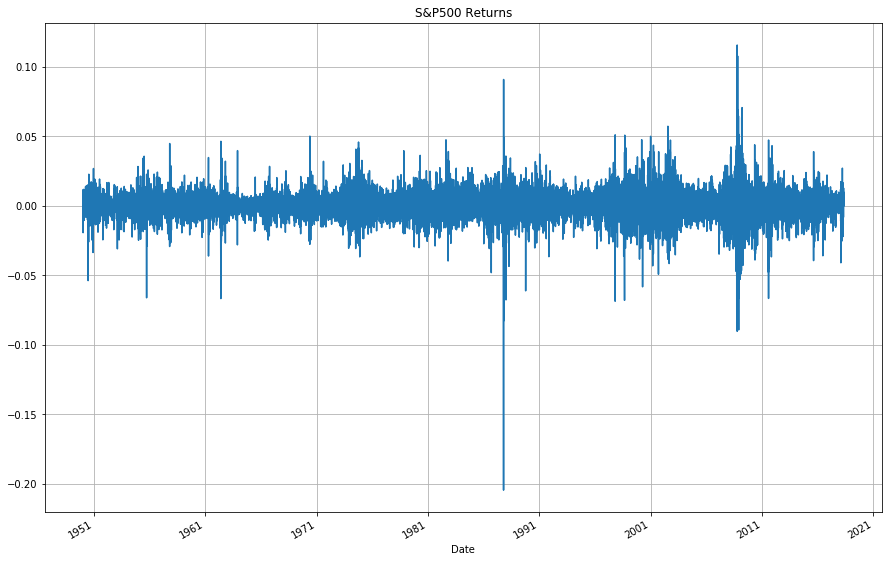

In [4]:
sp500_returns.plot(title='S&P500 Returns',grid=True, figsize=(15, 10));

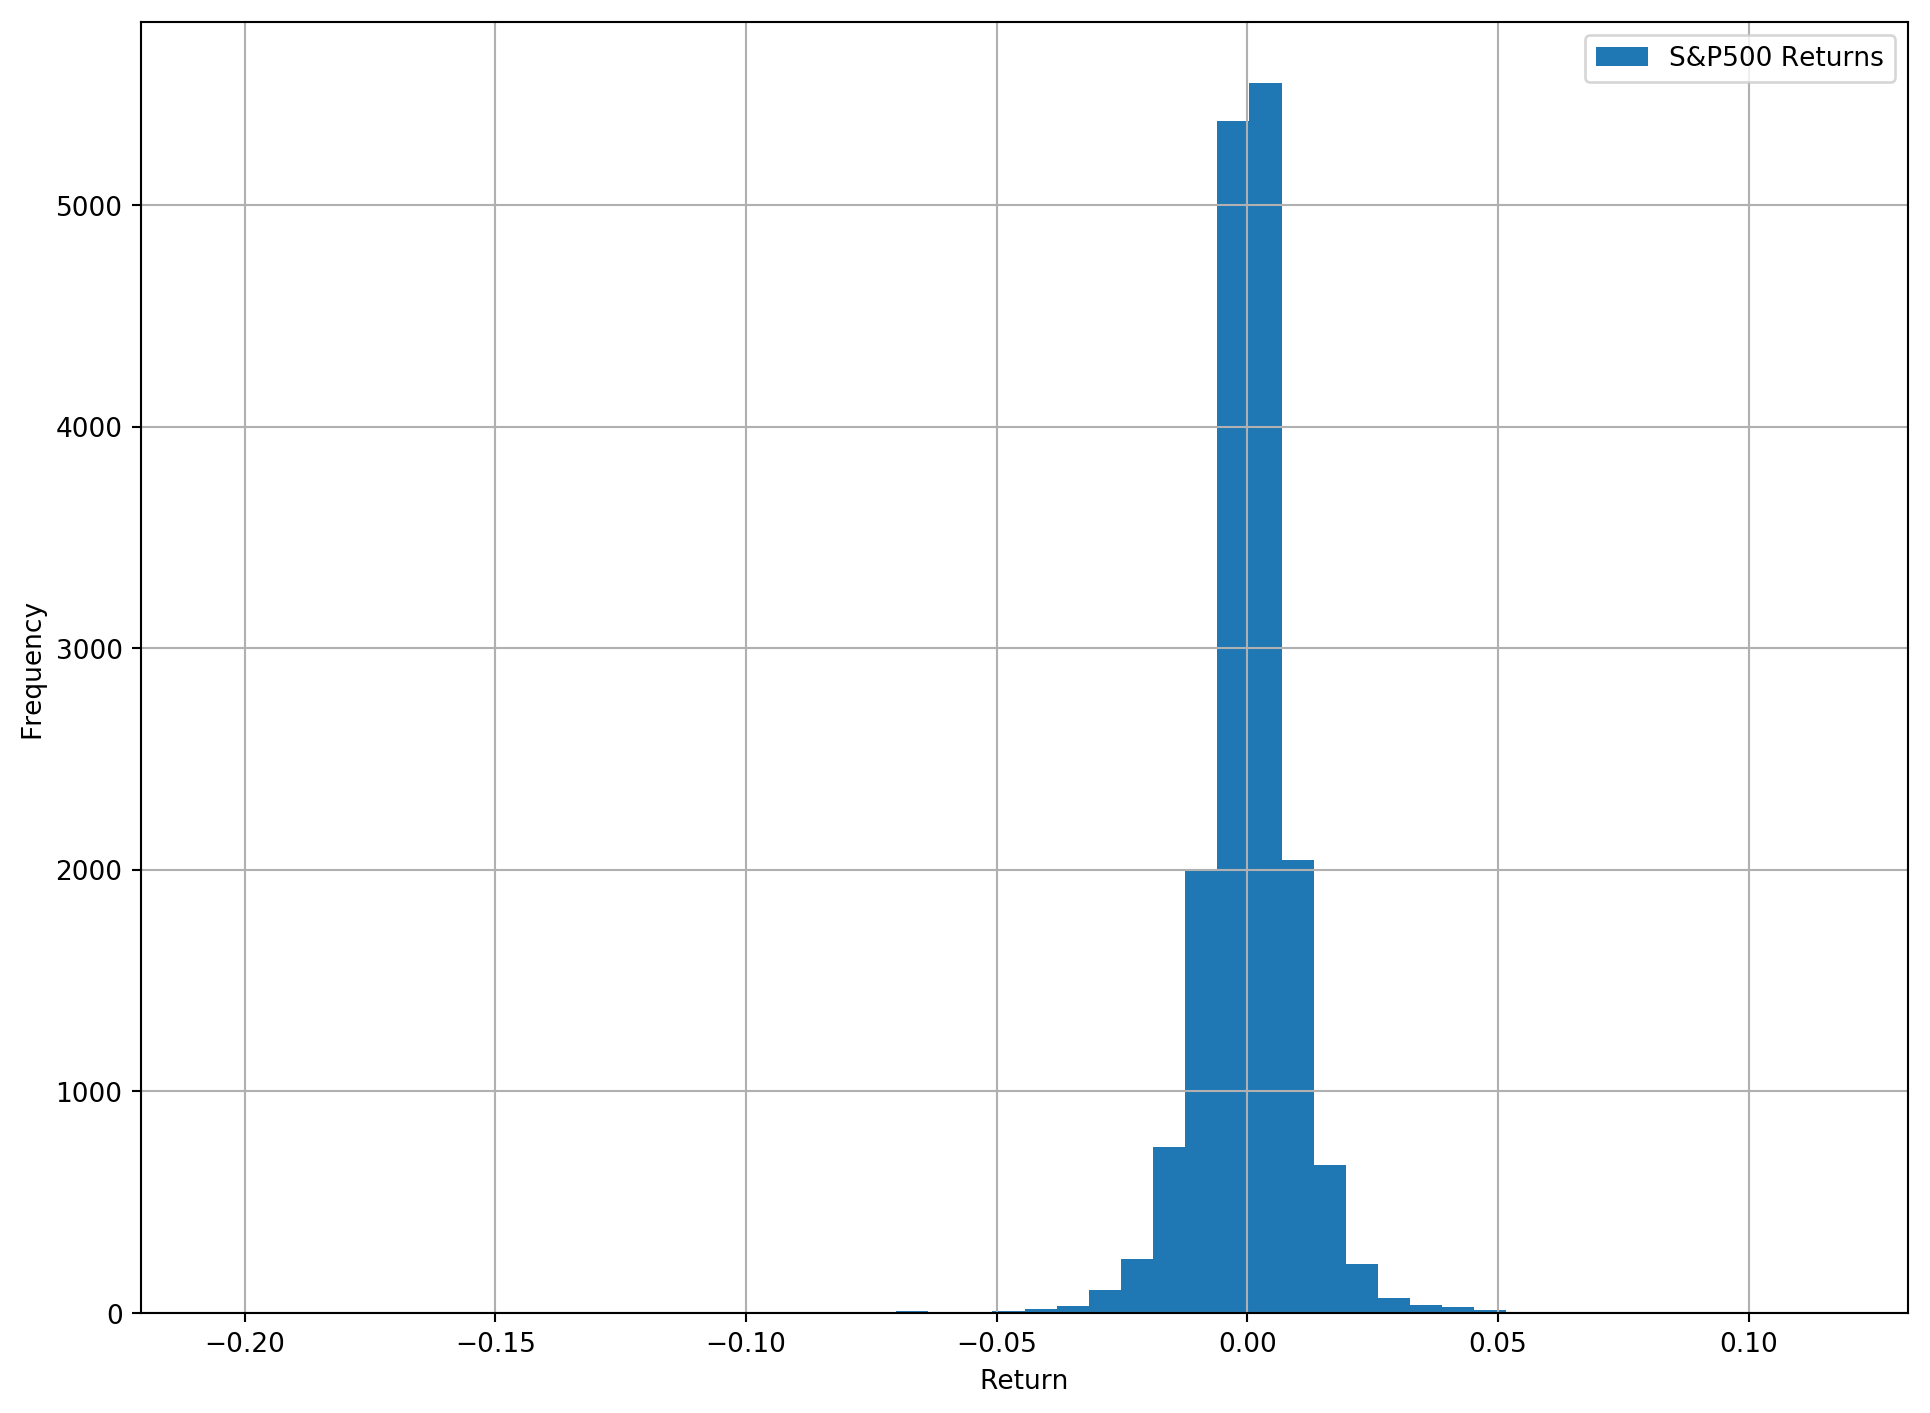

In [30]:
plt.figure(figsize=(12, 9), dpi=190)
plt.hist(sp500_returns, bins=50)
plt.grid(True)
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend(['S&P500 Returns']);

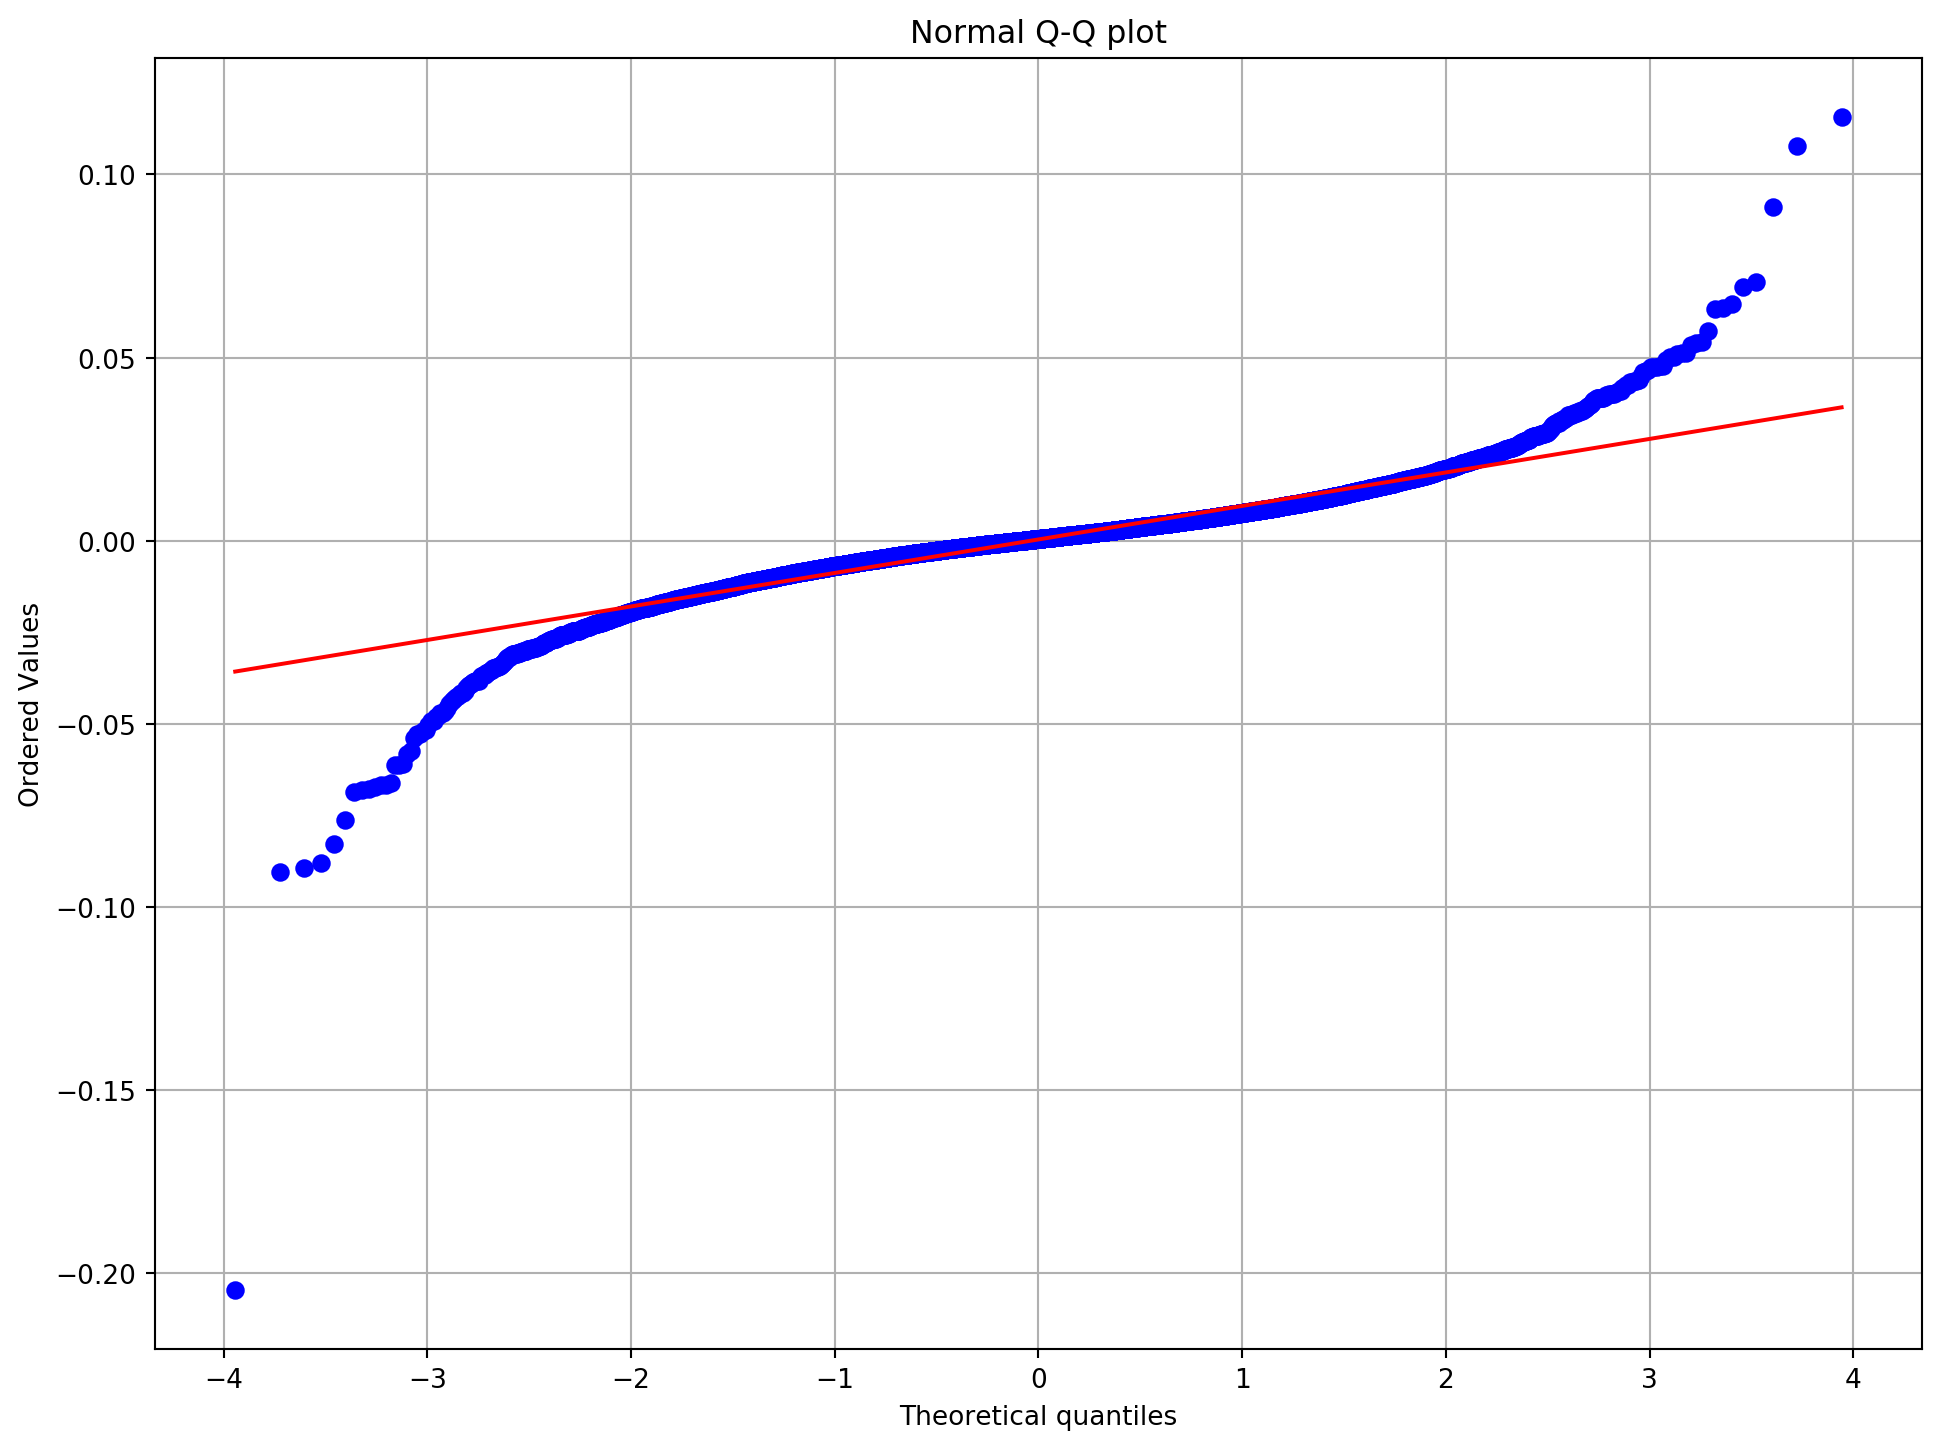

In [13]:
plt.figure(figsize=(12, 9), dpi=190)
stats.probplot(sp500_returns, dist="norm", plot=plt)
plt.grid(True)
plt.title("Normal Q-Q plot");

All three plots above suggest as expected that the S&P500 returns data does not come from a normal distribution. We further confirm this by calculating the kurtosis over the entire time series.

In [14]:
# testing kurtosis functions
scipy_kurtosis = kurtosis(sp500_returns, fisher=False)
print("Scipy version:", scipy_kurtosis)

Scipy version: 23.84959871116602


## Simple NoVaS Transform

We implement the simple NoVaS transform outlined above and select a lag parameter p that results in the transforming the data to a normal distribution. We confirm this by plotting the diagrams above for the transformed series $W_t$


In [15]:
def simple_novas(returns, p):
    """
    Function performs NoVaS (normalizing and variance stabilizing transformation) on financial returns series
    as outlined in Politis (2007)
    
    input:
        returns - daily financial returns
        p - lag parameter (first p-1 entries of o)
    output:
        W_t - NoVaS transformed series
    """
    
    n = len(returns)
    X_t = np.zeros(2*p+n) # placeholder vector containing returns upto period t
    X_t[2*p:2*p+n] = returns
    X_t = pd.Series(X_t)
    
    # to calculate denominator term, sum lag p squared returns
    lagged_squared_returns = pd.Series(np.zeros(len(X_t))) 
    for i in range(p):
        lagged_squared_returns = lagged_squared_returns + (X_t**2).shift(-i)
    
    W_t = X_t/np.sqrt(lagged_squared_returns/p)
    W_t = W_t[2*p:2*p+n] # drop extra lag indices in array
    W_t = W_t.dropna() # drop 
    return W_t

In [24]:
W_t = simple_novas(sp500_returns,16)
W_t.index = sp500_returns.index[15:]
kurtosis(W_t, fisher=False) # using pearson definition where Normal kurtosis = 3

3.005823580441774

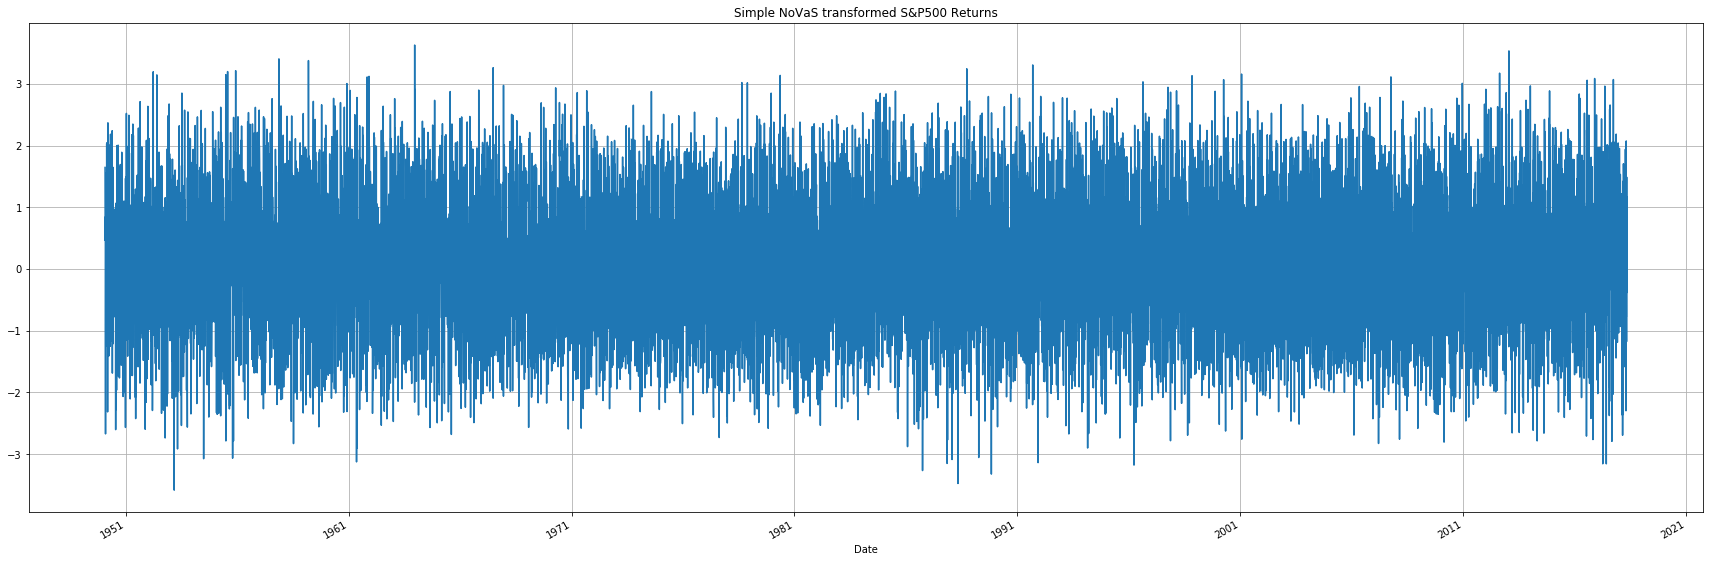

In [28]:
W_t.plot(title='Simple NoVaS transformed S&P500 Returns',grid=True, figsize=(30, 10));

Clearly returns above look to have been normalized by the transformation as there are no major outliners to be found

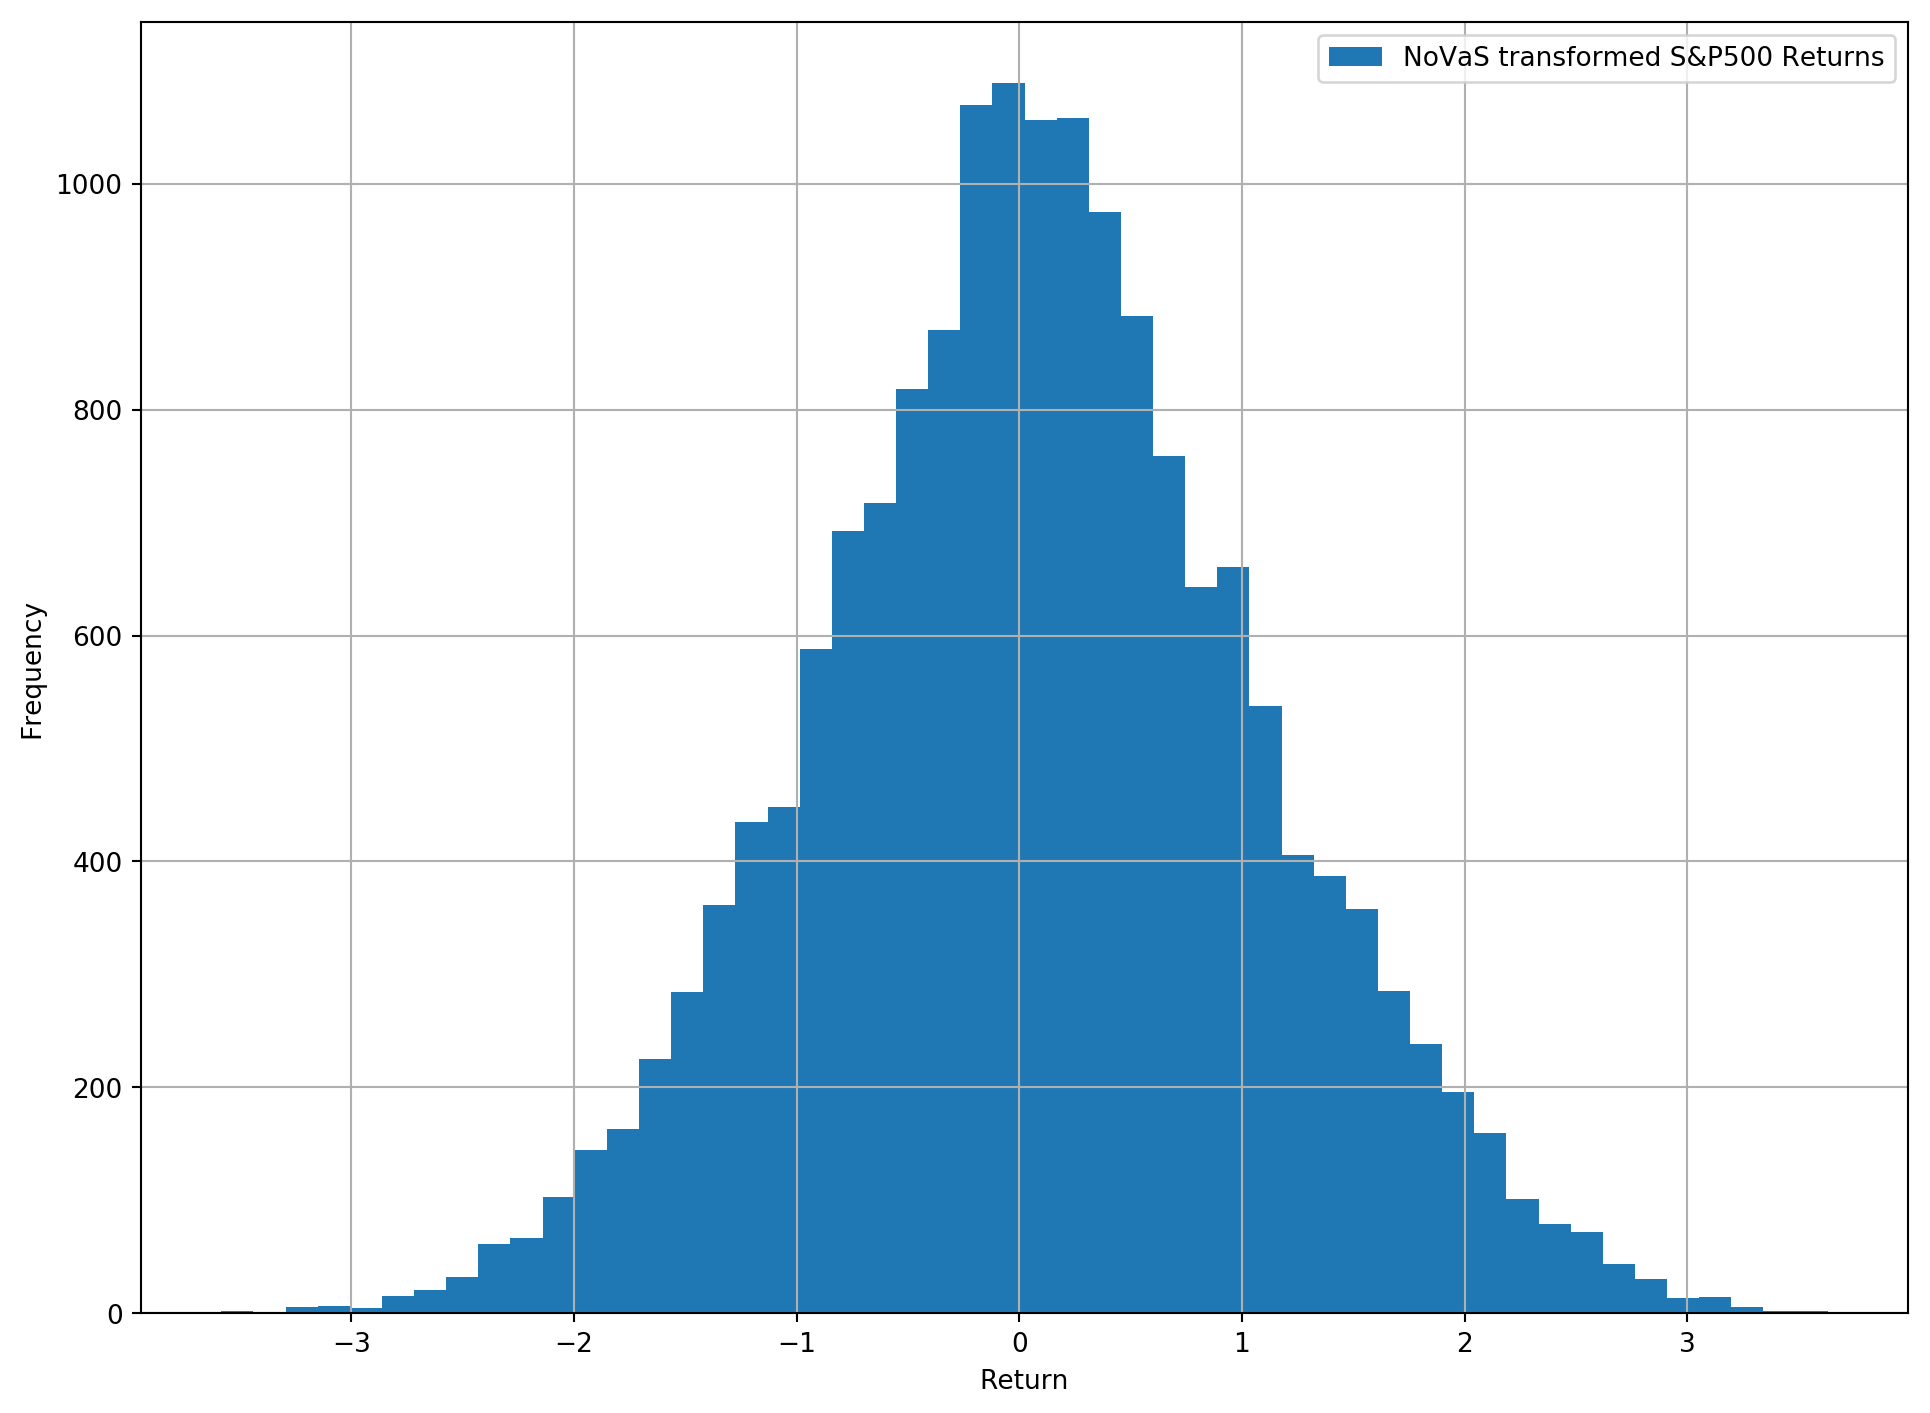

In [31]:
plt.figure(figsize=(12, 9), dpi=190)
plt.hist(W_t, bins=50)
plt.grid(True)
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend(['NoVaS transformed S&P500 Returns']);

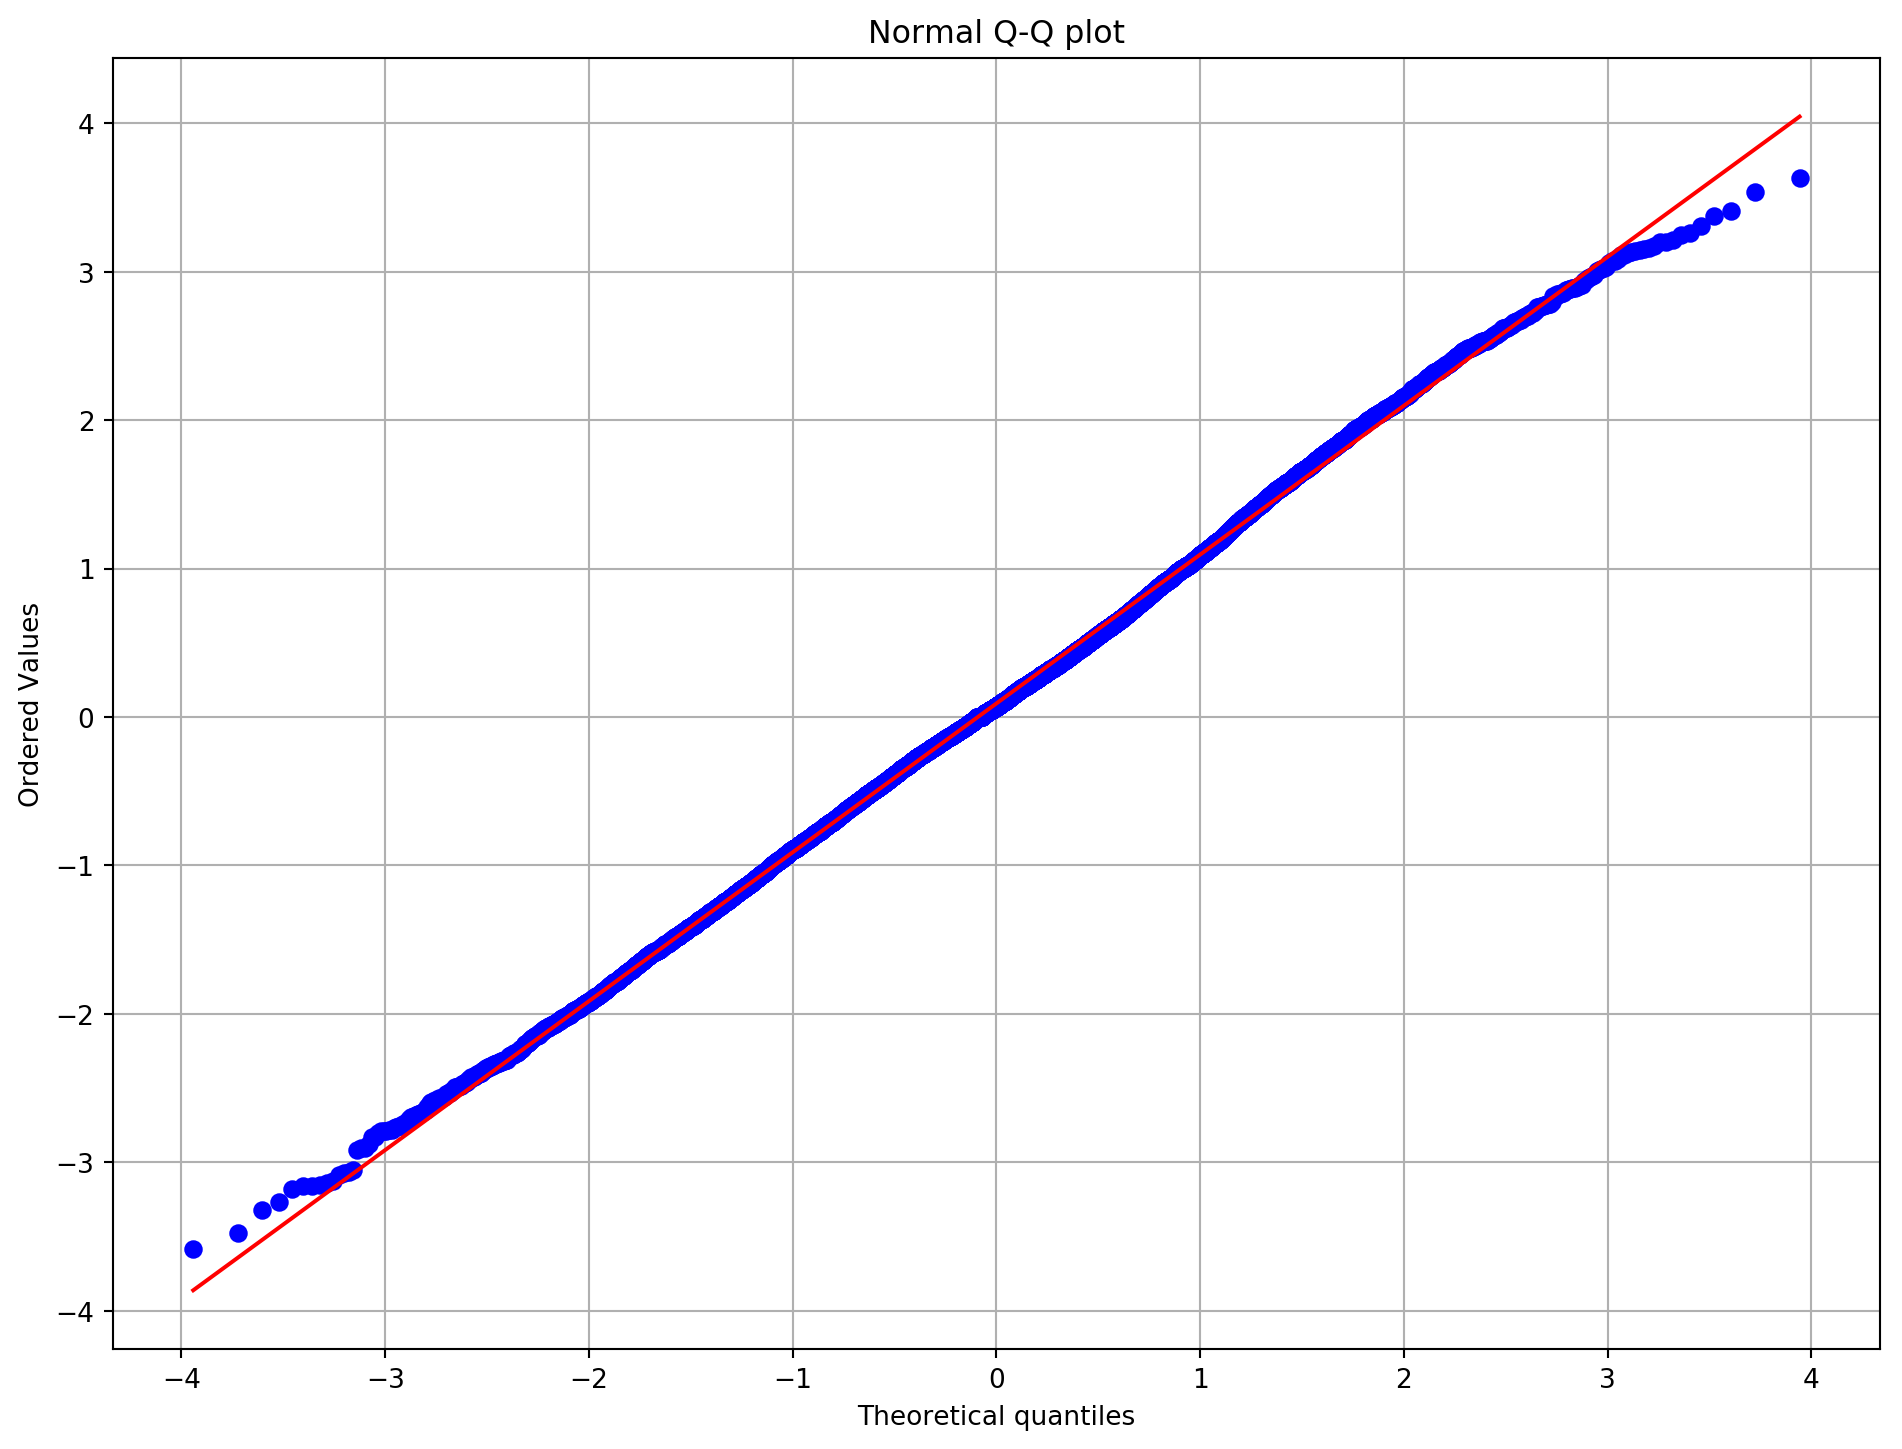

In [32]:
plt.figure(figsize=(12, 9), dpi=190)
stats.probplot(W_t, dist="norm", plot=plt)
plt.grid(True)
plt.title("Normal Q-Q plot");